# AC 221 Final Project Notebook

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Reading NYPD Stop, Question and Frisk Data

In [2]:
sqf_df = pd.read_csv('../data/sqf-2018.csv')
print(sqf_df.shape)
sqf_df.head()

(11008, 83)


,STOP_FRISK_ID,STOP_FRISK_DATE,Stop Frisk Time,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,RECORD_STATUS_CODE,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,LOCATION_IN_OUT_CODE,JURISDICTION_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,SUSPECTED_CRIME_DESCRIPTION,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,OTHER_PERSON_STOPPED_FLAG,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG,FRISKED_FLAG,SEARCHED_FLAG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_CEW_FLAG,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG,PHYSICAL_FORCE_OC_SPRAY_USED_FLAG,PHYSICAL_FORCE_OTHER_FLAG,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG,PHYSICAL_FORCE_WEAPON_IMPACT_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,SUSPECTS_ACTIONS_LOOKOUT_FLAG,SUSPECTS_ACTIONS_OTHER_FLAG,SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG,SEARCH_BASIS_ADMISSION_FLAG,SEARCH_BASIS_CONSENT_FLAG,SEARCH_BASIS_HARD_OBJECT_FLAG,SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG,SEARCH_BASIS_OTHER_FLAG,SEARCH_BASIS_OUTLINE_FLAG,DEMEANOR_CODE,DEMEANOR_OF_PERSON_STOPPED,SUSPECT_REPORTED_AGE,SUSPECT_SEX,SUSPECT_RACE_DESCRIPTION,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_PREMISES_NAME,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME
0,1,1/1/18,19:04:00,2018,January,Monday,Based on C/W on Scene,APP,POM,1,SGT,1,Y,(null),P,PSB,0,MENACING,18,Y,(null),Y,N,(null),N,(null),Y,(null),(null),(null),Y,N,N,(null),(null),(null),N,(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),Y,Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,COOPERATIVE,(null),MALE,WHITE,5.1,170,MED,BRO,BLK,(null),1,G,(null),VARICK STREET && FRANKLIN STREET,(null),VARICK STREET,982327,201274,(null),PBMS,MANHATTAN
1,2,1/1/18,23:00:00,2018,January,Monday,Based on Radio Run,APP,POM,34,SGT,34,N,O,P,PSB,1,CPW,15,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),Y,Y,N,(null),(null),(null),N,(null),Y,(null),(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),DE,NERVOUS,26,MALE,BLACK HISPANIC,6.1,250,HEA,BRO,BLK,(null),34,C,(null),DYCKMAN STREET && POST AVENUE,(null),DYCKMAN STREET,1004892,253548,(null),PBMN,MANHATTAN
2,3,1/1/18,23:55:00,2018,January,Monday,Based on Radio Run,APP,POM,808,SGT,808,Y,I,H,Housing,0,GRAND LARCENY,10,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),Y,N,N,(null),(null),(null),N,(null),(null),(null),(null),(null),(null),Y,(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,RELIEVED,40,MALE,WHITE HISPANIC,5.5,150,THN,BRO,BLD,(null),43,B,4M,2245 RANDALL AVENUE,(null),RANDALL AVENUE,1026706,237776,(null),PBBX,BRONX
3,4,1/1/18,3:23:00,2018,January,Monday,Based on Radio Run,APP,POM,63,SGT,63,Y,O,P,PSB,2,ROBBERY,15,Y,(null),Y,Y,ROBBERY,N,(null),Y,(null),(null),(null),Y,Y,N,(null),(null),(null),N,(null),(null),(null),(null),(null),Y,Y,(null),Y,(null),(null),(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),(null),Y,(null),DE,COMPLAIN,38,MALE,AMERICAN INDIAN/ALASKAN NATIVE,5.1,

## Data Cleaning

In [3]:
# drop unnecessary variables
def drop_unnecessary_variables(df, variables_list):
    return df.drop(variables_list, axis=1)

# dealing with missing values
def deal_with_missing_values(df):
    return df.replace('(null)', np.nan)

# convert Y/N flag columns to boolean
def convert_flags_to_boolean(df):
    binary_map_dict = {'Y': 1, 'N': 0, np.nan: 0, 'I':1, 'S':1, 'V':1}
    
    # carrying out this operation for flags
    for col in df.columns: 
        if 'FLAG' in col:
            df[col] = list(map(lambda x: binary_map_dict[x], df[col]))
    return df
            
# convert categorical variables to one-hot-encoding
def make_one_hot(df, var):
    one_hot = pd.get_dummies(df[var])
    df = df.drop(var,axis = 1)
    df = df.join(one_hot)
    return df

# specific transformations for height: converting feet to inches
def replace_feet_inches(h):
    try:
        height = str(h).split('.')
        return int(height[0])*12 + int(height[1])
    except:
        return h
    
# specific transformations
def specific_variable_transformations(df):
    # height
    df = replace_with_function(df, 'SUSPECT_HEIGHT', replace_feet_inches)
    return df

# replaces values in a variable with a mapping
def replace_with_map(df, var, map_dict):
    df[var] = list(map(lambda x: map_dict[x], df[var]))
    return df

# replaces values in a variable with a function
def replace_with_function(df, var, function):
    df[var] = list(map(lambda x: function(x), df[var]))
    return df

In [4]:
def data_cleaning_pipeline(df):
    # carrying out data cleaning using helper functions defined above
    unnecessary_variables = ['STOP_LOCATION_PREMISES_NAME', 'STOP_FRISK_ID']
    df = drop_unnecessary_variables(df, unnecessary_variables)

    # dealing with missing values
    df = deal_with_missing_values(df)

    # convert Y/N flags to booleans and doing the same for gender
    df = convert_flags_to_boolean(df)
    df = replace_with_map(df, 'SUSPECT_SEX', {'MALE': 1, 'FEMALE': 0, np.nan: np.nan})

    # specific variable transformations
    df = specific_variable_transformations(df)

    # convert categorical variables to one-hot
    df = make_one_hot(df, 'SUSPECT_RACE_DESCRIPTION')
    df = make_one_hot(df, 'SUSPECTED_CRIME_DESCRIPTION')
    # TODO: borough, officer rank
    
    # done
    print('Cleaned dataframe shape: {}'.format(df.shape))
    return df

In [5]:
clean_sqf_df = data_cleaning_pipeline(sqf_df)
clean_sqf_df.head()

Cleaned dataframe shape: (11008, 112)


,STOP_FRISK_DATE,Stop Frisk Time,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,RECORD_STATUS_CODE,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,LOCATION_IN_OUT_CODE,JURISDICTION_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,OTHER_PERSON_STOPPED_FLAG,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG,FRISKED_FLAG,SEARCHED_FLAG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_CEW_FLAG,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG,PHYSICAL_FORCE_OC_SPRAY_USED_FLAG,PHYSICAL_FORCE_OTHER_FLAG,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG,PHYSICAL_FORCE_WEAPON_IMPACT_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,...,SUSPECT_SEX,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,WHITE,WHITE HISPANIC,ASSAULT,AUTO STRIPPIG,BURGLARY,CPSP,CPW,CRIMINAL MISCHIEF,CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,CRIMINAL POSSESSION OF FORGED INSTRUMENT,CRIMINAL POSSESSION OF MARIHUANA,CRIMINAL SALE OF CONTROLLED SUBSTANCE,CRIMINAL SALE OF MARIHUANA,CRIMINAL TRESPASS,FORCIBLE TOUCHING,GRAND LARCENY,GRAND LARCENY AUTO,MAKING GRAFFITI,MENACING,MURDER,OTHER,PETIT LARCENY,PROSTITUTION,RAPE,RECKLESS ENDANGERMENT,ROBBERY,TERRORISM,THEFT OF SERVICES,UNAUTHORIZED USE OF A VEHICLE
0,1/1/18,19:04:00,2018,January,Monday,Based on C/W on Scene,APP,POM,1,SGT,1,Y,NaN,P,PSB,0,18,1,NaN,1,0,NaN,0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,...,1.0,61,170,MED,BRO,BLK,NaN,1,G,NaN,VARICK STREET && FRANKLIN STREET,VARICK STREET,982327,201274,NaN,PBMS,MANHATTAN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1/1/18,23:00:00,2018,January,Monday,Based on Radio Run,APP,POM,34,SGT,34,N,O,P,PSB,1,15,1,NaN,0,0,NaN,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1.0,73,250,HEA,BRO,BLK,NaN,34,C,NaN,DYCKMAN STREET && POST AVENUE,DYCKMAN STREET,1004892,253548,NaN,PBMN,MANHATTAN,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1/1/18,23:55:00,2018,January,Monday,Based on Radio Run,APP,POM,808,SGT,808,Y,I,H,Housing,0,10,1,NaN,0,0,NaN,0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,...,1.0,65,150,THN,BRO,BLD,NaN,43,B,4M,2245 RANDALL AVENUE,RANDALL AVENUE,1026706,237776,NaN,PBBX,BRONX,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1/1/18,3:23:00,2018,January,Monday,Based on Radio Run,APP,POM,63,SGT,63,Y,O,P,PSB,2,15,1,NaN,1,1,ROBBERY,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,...,1.0,61,160,MED,BRO,BLK,NaN,63,B,NaN,EAST 38 STREET && AVENUE L,EAST 38 STREET,1001347,166195,NaN,PBBS,BROOKLYN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1/1/18,3:23:00,2018,January,Monday,Based on Radio Run,APP,POM,63,SGT,63,Y,NaN,P,PSB,2,15,1,NaN,1,1,ROBBERY,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,...,1.0,71,230,MED,BRO,BLK,NaN,63,B,NaN,EAST 38 STREET && AVENUE L,EAST 38 STREET,1001347,166195,NaN,PBBS,BROOKLYN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Exploratory Data Analysis

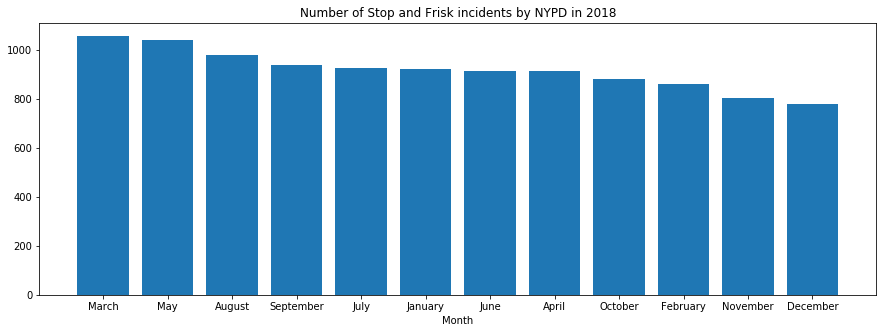

In [6]:
temp = sqf_df['MONTH2'].value_counts()
fig, ax = plt.subplots(1,1, figsize = (15, 5))
ax.bar(temp.index, temp.values)
ax.set_title("Number of Stop and Frisk incidents by NYPD in 2018")
ax.set_xlabel("Month");

### Visualizing Race

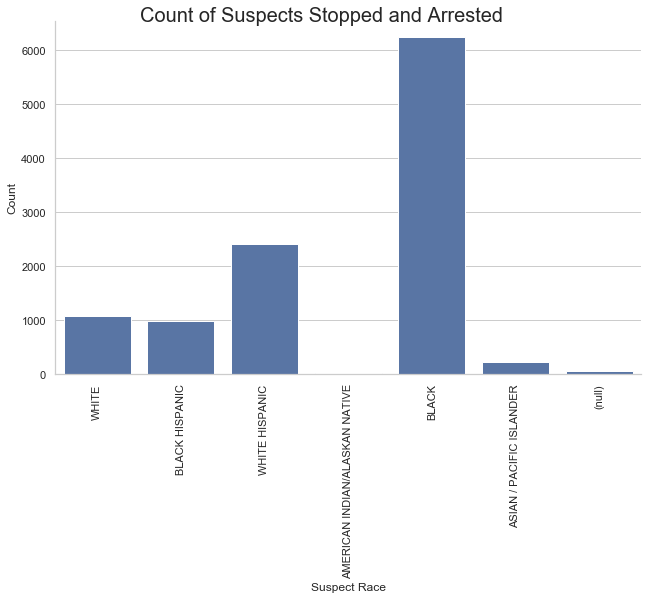

In [7]:
sqf_df['count'] = 1 # for color purpose later
sns.set(style="whitegrid")
# use hue='count' for one color
ax = sns.catplot(x="SUSPECT_RACE_DESCRIPTION", kind="count", data=sqf_df, hue="count", legend=False)
ax.fig.set_size_inches(10,6)
ax.set_axis_labels("Suspect Race", "Count")
ax.fig.suptitle("Count of Suspects Stopped and Arrested", fontsize = 20)
ax.set_xticklabels(rotation = 90);

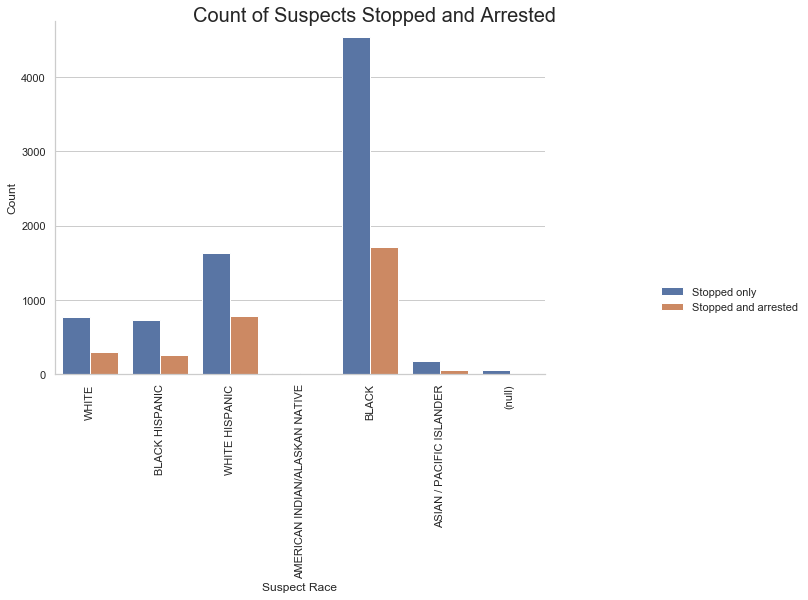

In [8]:
# temp = sqf_df['SUSPECT_RACE_DESCRIPTION'].value_counts()
sns.set(style="whitegrid")
ax = sns.catplot(x="SUSPECT_RACE_DESCRIPTION", hue="SUSPECT_ARRESTED_FLAG", kind="count", data=sqf_df)
ax.fig.set_size_inches(12,6)
ax.set_axis_labels("Suspect Race", "Count")
ax.fig.suptitle("Count of Suspects Stopped and Arrested", fontsize = 20)

# title
ax._legend.set_title("")

# legend
new_labels = ['Stopped only', 'Stopped and arrested']
for t, l in zip(ax._legend.texts, new_labels): 
    t.set_text(l)
ax.set_xticklabels(rotation = 90);

### Visualizing Gender

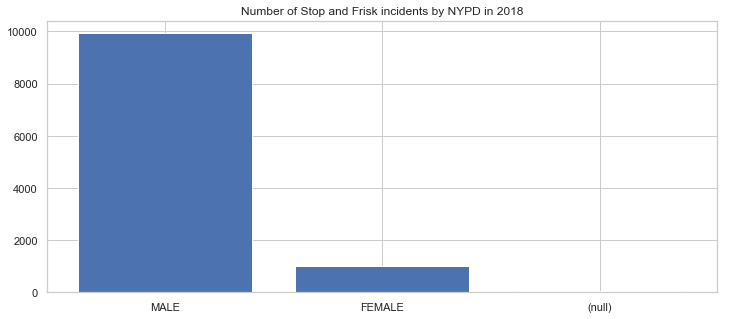

In [9]:
temp = sqf_df['SUSPECT_SEX'].value_counts()
fig, ax = plt.subplots(1,1, figsize = (12, 5))
ax.bar(temp.index, temp.values);
ax.set_title("Number of Stop and Frisk incidents by NYPD in 2018");

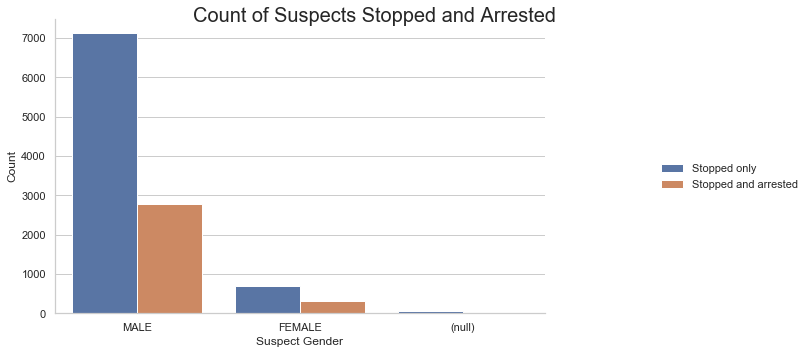

In [10]:
# temp = sqf_df['SUSPECT_RACE_DESCRIPTION'].value_counts()
sns.set(style="whitegrid")
ax = sns.catplot(x="SUSPECT_SEX", hue="SUSPECT_ARRESTED_FLAG", kind="count", data=sqf_df)
ax.fig.set_size_inches(12,5)
ax.set_axis_labels("Suspect Gender", "Count")
ax.fig.suptitle("Count of Suspects Stopped and Arrested", fontsize = 20)

# title
ax._legend.set_title("")

# legend
new_labels = ['Stopped only', 'Stopped and arrested']
for t, l in zip(ax._legend.texts, new_labels): 
    t.set_text(l);

### Visualizing Age

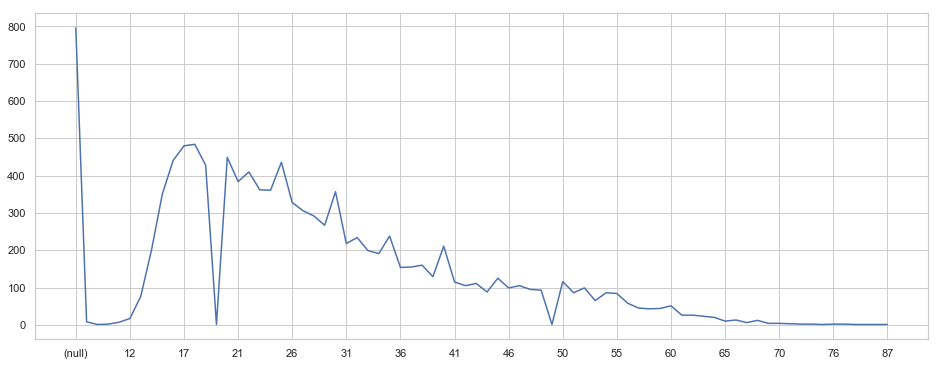

In [11]:
temp = dict(sqf_df['SUSPECT_REPORTED_AGE'].value_counts())
keys = sorted(temp.keys())
values = [temp[k] for k in keys]

fig, ax = plt.subplots(1,1, figsize = (16, 6))
ax.set_xticks(range(0,100,5))
ax.plot(keys, values);

## Modeling

### Model 1: Random Forest Model Using Select Features

In [12]:
model_df = clean_sqf_df.select_dtypes(include=['int64', 'uint8', 'float64']).dropna(axis=0)
y = model_df['SUSPECT_ARRESTED_FLAG']
X = model_df[model_df.columns.difference(['SUSPECT_ARRESTED_FLAG'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model_1 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model_1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [13]:
model_1.score(X_test, y_test)

0.7717451523545706

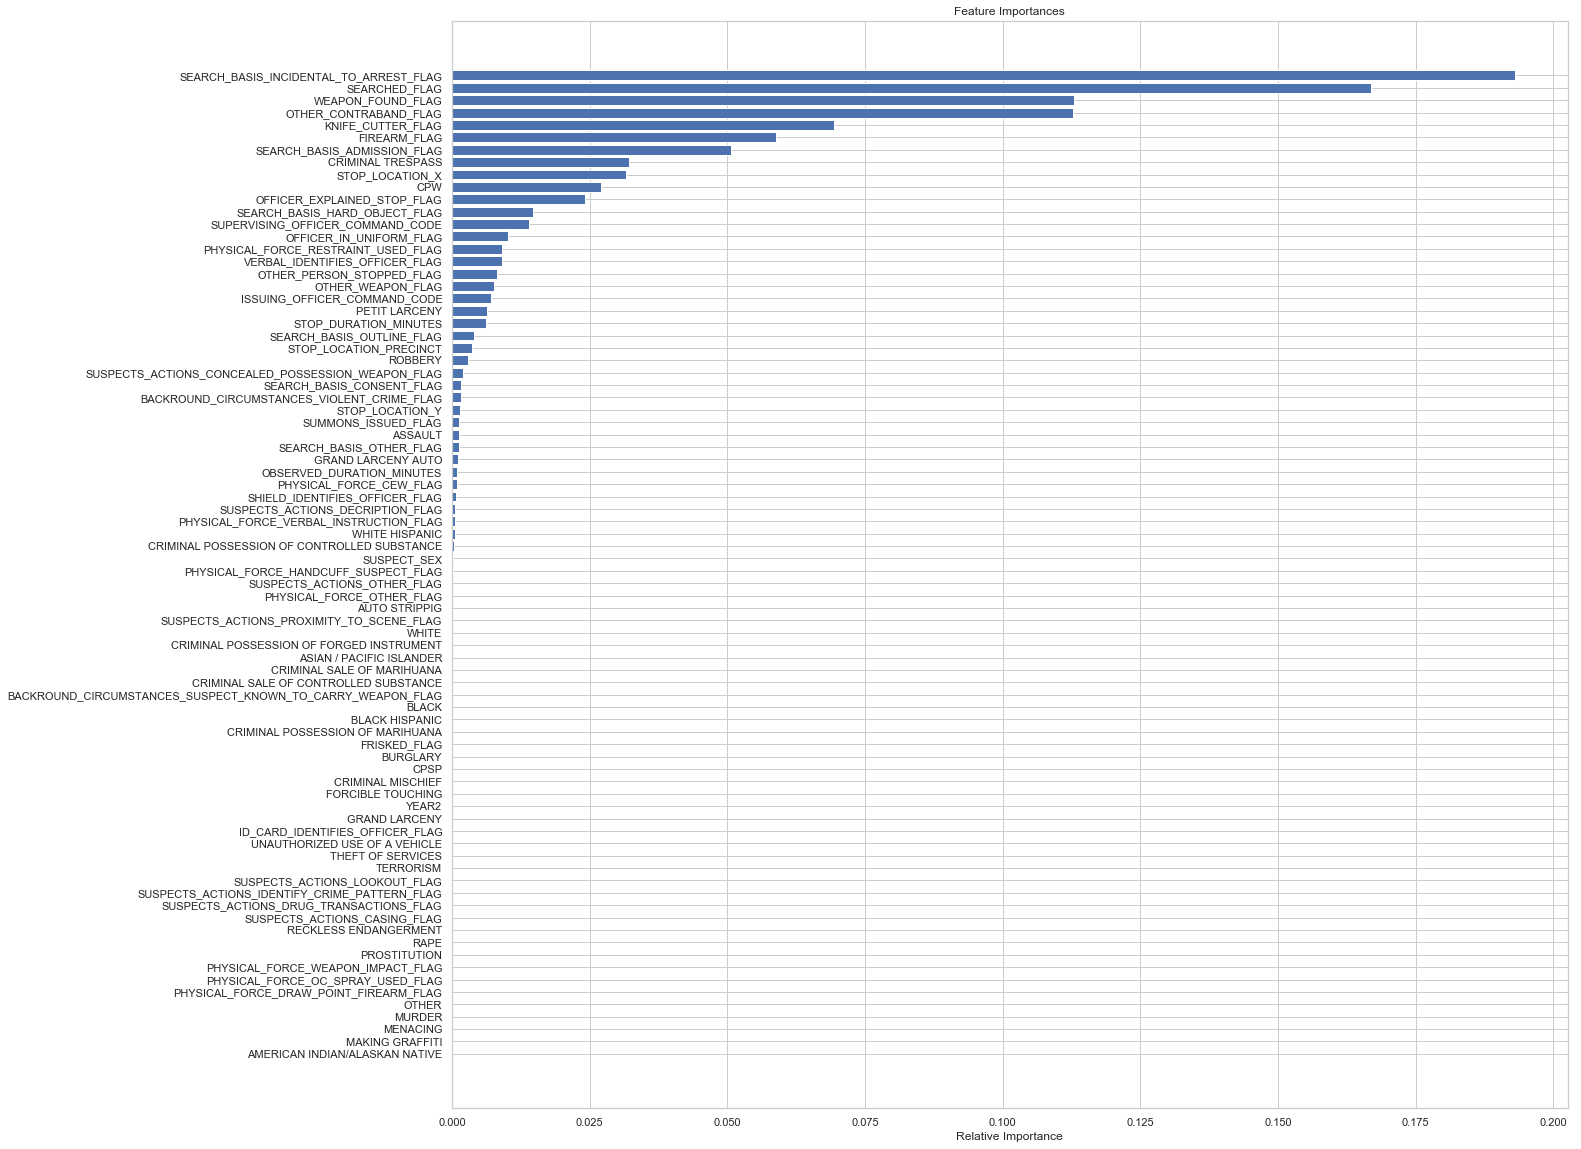

In [14]:
features = X_train.columns
importances = model_1.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(20,20))
ax.barh(range(len(indices)), importances[indices], color='b', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([features[i] for i in indices])
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importances');

### Model 2: TBD

## Fairness Analysis

---